## P5.2 Topic Modeling

---

### Content
- [Topic Modelling using LDA](#Topic-Modelling-using-LDA)
- [Topic Modeling (Train data)](#Topic-Modeling-(Train-data))
- [Optimal Topic Size](#Optimal-Topic-Size)
- [Binary Classification (LDA topic features)](#Binary-Classification-(LDA-topic-features))
- [Binary Classification (LDA topic and Countvectorizer features)](#Binary-Classification-(LDA-topic-and-Countvectorizer-features))
- [Recommendations (Part2)](#Recommendations-(Part2))
- [Future Work](#Future-Work)

### Topic Modelling using LDA
Inspired by Marc Kelechava's work [https://towardsdatascience.com/unsupervised-nlp-topic-models-as-a-supervised-learning-input-cf8ee9e5cf28] and Andrew Ng et al., 2003.

In this section, I explore if underlying semantic structures, discovered through the Latent Dirichlet Allocation (LDA) technique (unsupervised machine learning technique), could be utilized in a supervised text classification problem. LDA application poses significant challenge due to personal inexperience in the domain, and I allocated approx. a week in reading up on basic LDA applications. I'm interested to explore 

Steps as follows:
- Explore LDA topic modelling, and derive optimum number of topics (train data)
- Investigate the use of LDA topic distributions as feature vectors for supervised, binary classification (i.e. bomb or non-bomb). If the supervised sensitivty and roc_auc score on the unseen data generalizes, it is an indication that the topic model trained on trainsub has identified latent semantic structure that persists over varying motive texts in identification of bombing incidents.
- Investigate generalizability of supervised, binary classification model using feature vectors from both LDA and countvectorizer. 

In [1]:
import pandas as pd
import numpy as np
import sys
import re
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel

# NLTK Stop words and stemmer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

# Import library for cross-validation
from sklearn.model_selection import cross_val_score, cross_val_predict

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# Setting - display all columns
pd.set_option('display.max_columns', None)

In [3]:
# Read in cleaned featured engineered data
dframe = pd.read_csv('../assets/wordok.csv',encoding="ISO-8859-1",index_col=0)

In [4]:
# Instantiate the custom list of stopwords for modelling from P5_01
stop_words = stopwords.words('english')

own_stop = ['motive','specific','unknown','attack','sources','noted', 'claimed','stated','incident','targeted',\
            'responsibility','violence','carried','government','suspected','trend','speculated','al','sectarian',\
            'retaliation','group','related','security','forces','people','bomb','bombing','bombings']
# Extend the stop words
stop_words.extend(own_stop)

In [5]:
own_stopfn = ['death', 'want', 'off', 'momentum', 'star', 'colleg', 'aqi', 'treat', 'reveng', 'them', 'all', 'radio',\
              'bodo', 'upcom', 'between', 'prior', 'enter', 'made', 'nimr', 'sectarian', 'muslim', 'past', 'previou',\
              'intimid', 'held', 'fsa', 'women', 'are', 'mnlf', 'with', 'pattani', 'shutdown', 'border', 'departur',\
              'advoc', 'have', 'eelam', 'across', 'villag', 'foreign', 'kill', 'shepherd', 'yemeni', 'develop', 'pro',\
              'road', 'not', 'appear', 'jharkhand', 'spokesperson']

In [6]:
# Extend the Stop words
stop_words.extend(own_stopfn)
# Check the addition of firstset_words
stop_words[-5:]

['road', 'not', 'appear', 'jharkhand', 'spokesperson']

In [7]:
# Create Train-Test split (80-20 split)
# X is motive text. y is bomb.
X_train,X_test,y_train,y_test = train_test_split(dframe[['motive']],dframe['bomb'],test_size=0.20,\
                                                 stratify=dframe['bomb'],\
                                                 random_state=42)

In [8]:
dframe.head(1)

,eventid,iyear,imonth,iday,country,region,lat,lon,crit1,crit2,crit3,success,suicide,atkmode,targtype,targnat,gname,motive,indiv,weaptype,nkill,nwound,property,bomb
0,197001010002,1970,1,1,United States,North America,37.005105,-89.176269,1,1,1,1,0,armed assault,police,united states,black nationalists,to protest the cairo illinois police deparment,0,firearms,0,0,1,0


### Topic Modeling (Train data)

In [9]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
data = X_train.motive.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])

[['the', 'specific', 'motive', 'is', 'unknown', 'however', 'sources', 'speculate', 'that', 'the', 'attack', 'was', 'part', 'of', 'larger', 'trend', 'of', 'sectarian', 'violence', 'between', 'iraqs', 'minority', 'sunni', 'and', 'majority', 'shiite', 'communities']]


Utilize Gensim's `Phrases` to build and implement bigrams and trigrams. The higher the parameters `min_count` and `threshold`, the harder it is for words to be combined to bigrams

In [10]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    # use 'en_core_web_sm' in place of 'en' 
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data

In [11]:
len(data_ready)

26016

In [12]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

## Create corpus texts
texts = data_ready

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# View
display(corpus[:4])

# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:4]]

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1)],
 [],
 [],
 [(1, 1), (2, 1), (4, 1), (7, 1), (8, 1)]]

[[('community', 1),
  ('however', 1),
  ('large', 1),
  ('minority', 1),
  ('part', 1),
  ('shiite', 1),
  ('speculate', 1)],
 [],
 [],
 [('however', 1), ('large', 1), ('part', 1), ('begin', 1), ('may', 1)]]

Gensim creates unique id for each word in the document. The produced corpus shown above is a mapping of (word_id, word_frequency). A human-readable form of the corpus is displayed follows thereafter.

Build LDA model with 4 topics. Each topic is a combination of keywords (Each contributing certain weightage to topic).

In [13]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=42,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

pprint(lda_model.print_topics())

[(0,
  '0.060*"police" + 0.044*"believe" + 0.027*"protest" + 0.020*"response" + '
  '0.016*"informant" + 0.014*"intimidate" + 0.011*"rebel" + 0.009*"several" + '
  '0.009*"refuse" + 0.009*"often"'),
 (1,
  '0.067*"however" + 0.052*"election" + 0.036*"area" + 0.026*"attempt" + '
  '0.017*"recent" + 0.017*"local" + 0.016*"schedule" + 0.013*"extremist" + '
  '0.012*"also" + 0.011*"official"'),
 (2,
  '0.098*"however" + 0.049*"victim" + 0.043*"state" + 0.030*"posit" + '
  '0.029*"military" + 0.026*"campaign" + 0.022*"member" + 0.019*"accuse" + '
  '0.018*"maoist" + 0.018*"islamic"'),
 (3,
  '0.123*"however" + 0.077*"part" + 0.052*"large" + 0.050*"may" + '
  '0.045*"shiite" + 0.036*"community" + 0.022*"occur" + 0.021*"sunni" + '
  '0.017*"camp" + 0.017*"member"')]


Interpretation: For topic 0, top 10 keywords that contribute to this topic are 'however', 'state' and so on, with weight of 'however' being 0.088.

In [14]:
# Compute Perplexity
print(f"Perplexity: {lda_model.log_perplexity(corpus)}")  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_ready, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print(f"Coherence Score: {coherence_lda}")

Perplexity: -6.809074529210312
Coherence Score: 0.33088686316810534


In [15]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,3.0,0.9059,"however, part, large, may, shiite, community, ...","[however, speculate, part, large, minority, sh..."
1,1,0.0,0.2500,"police, believe, protest, response, informant,...",[]
2,2,0.0,0.2500,"police, believe, protest, response, informant,...",[]
3,3,3.0,0.8743,"however, part, large, may, shiite, community, ...","[however, may, part, large, begin]"
4,4,0.0,0.2500,"police, believe, protest, response, informant,...",[]
5,5,0.0,0.2500,"police, believe, protest, response, informant,...",[]
6,6,0.0,0.2500,"police, believe, protest, response, informant,...",[]
7,7,1.0,0.5309,"however, election, area, attempt, recent, loca...","[state, coordinate, intensify, operation, insu..."
8,8,3.0,0.4748,"however, part, large, may, shiite, community, ...","[however, authority, operation, target, provin..."
9,9,2.0,0.7854,"however, victim, state, posit, military, campa...","[however, know, fight, perceive, political, ec..."


The dominant topic with percentage contribution for each document is represented above. 


In [16]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 80

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9242,"police, believe, protest, response, informant, intimidate, rebel, several, r...","[protest, directive, aim, widen, tax, base, target, unregistered, incomplian..."
1,1.0,0.9368,"however, election, area, attempt, recent, local, schedule, extremist, also, ...","[however, presidential, run, election, schedule, also, vow, target, afghan, ..."
2,2.0,0.9315,"however, victim, state, posit, military, campaign, member, accuse, maoist, i...","[however, posit, islamic, state, accuse, victim, criticize, isil, social, me..."
3,3.0,0.9620,"however, part, large, may, shiite, community, occur, sunni, camp, member","[however, victim, shiite, may, part, large, majority, shiite, minority, sunn..."


The documents a given topic has contributed to the most to facilitate topic inference ate displayed above.

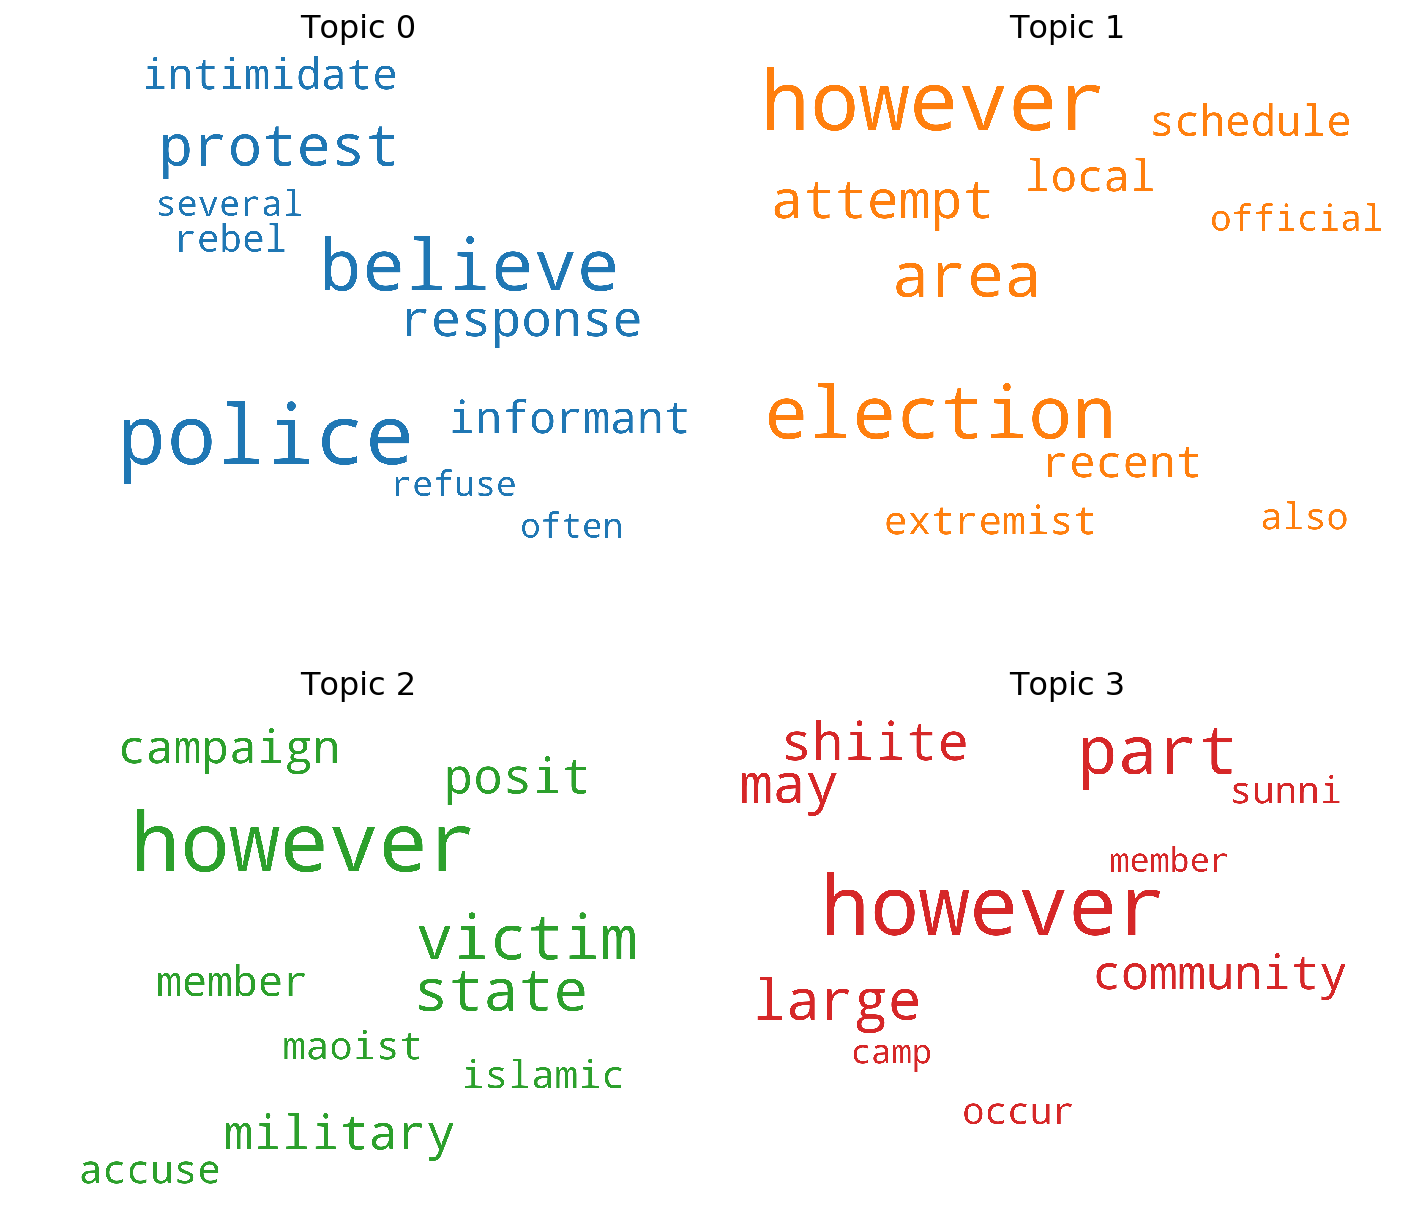

In [17]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

Interpretation of the Four topics using the representative text identified above: (topic 0: public unrest and law enforcement), (topic 1: tension admist elections), (topic 2: military campaigns and terror groups), (topic 3: sectarian violence). 
Note: Changing the random_seed will also change the topics surfaced, currently versioned as 42.

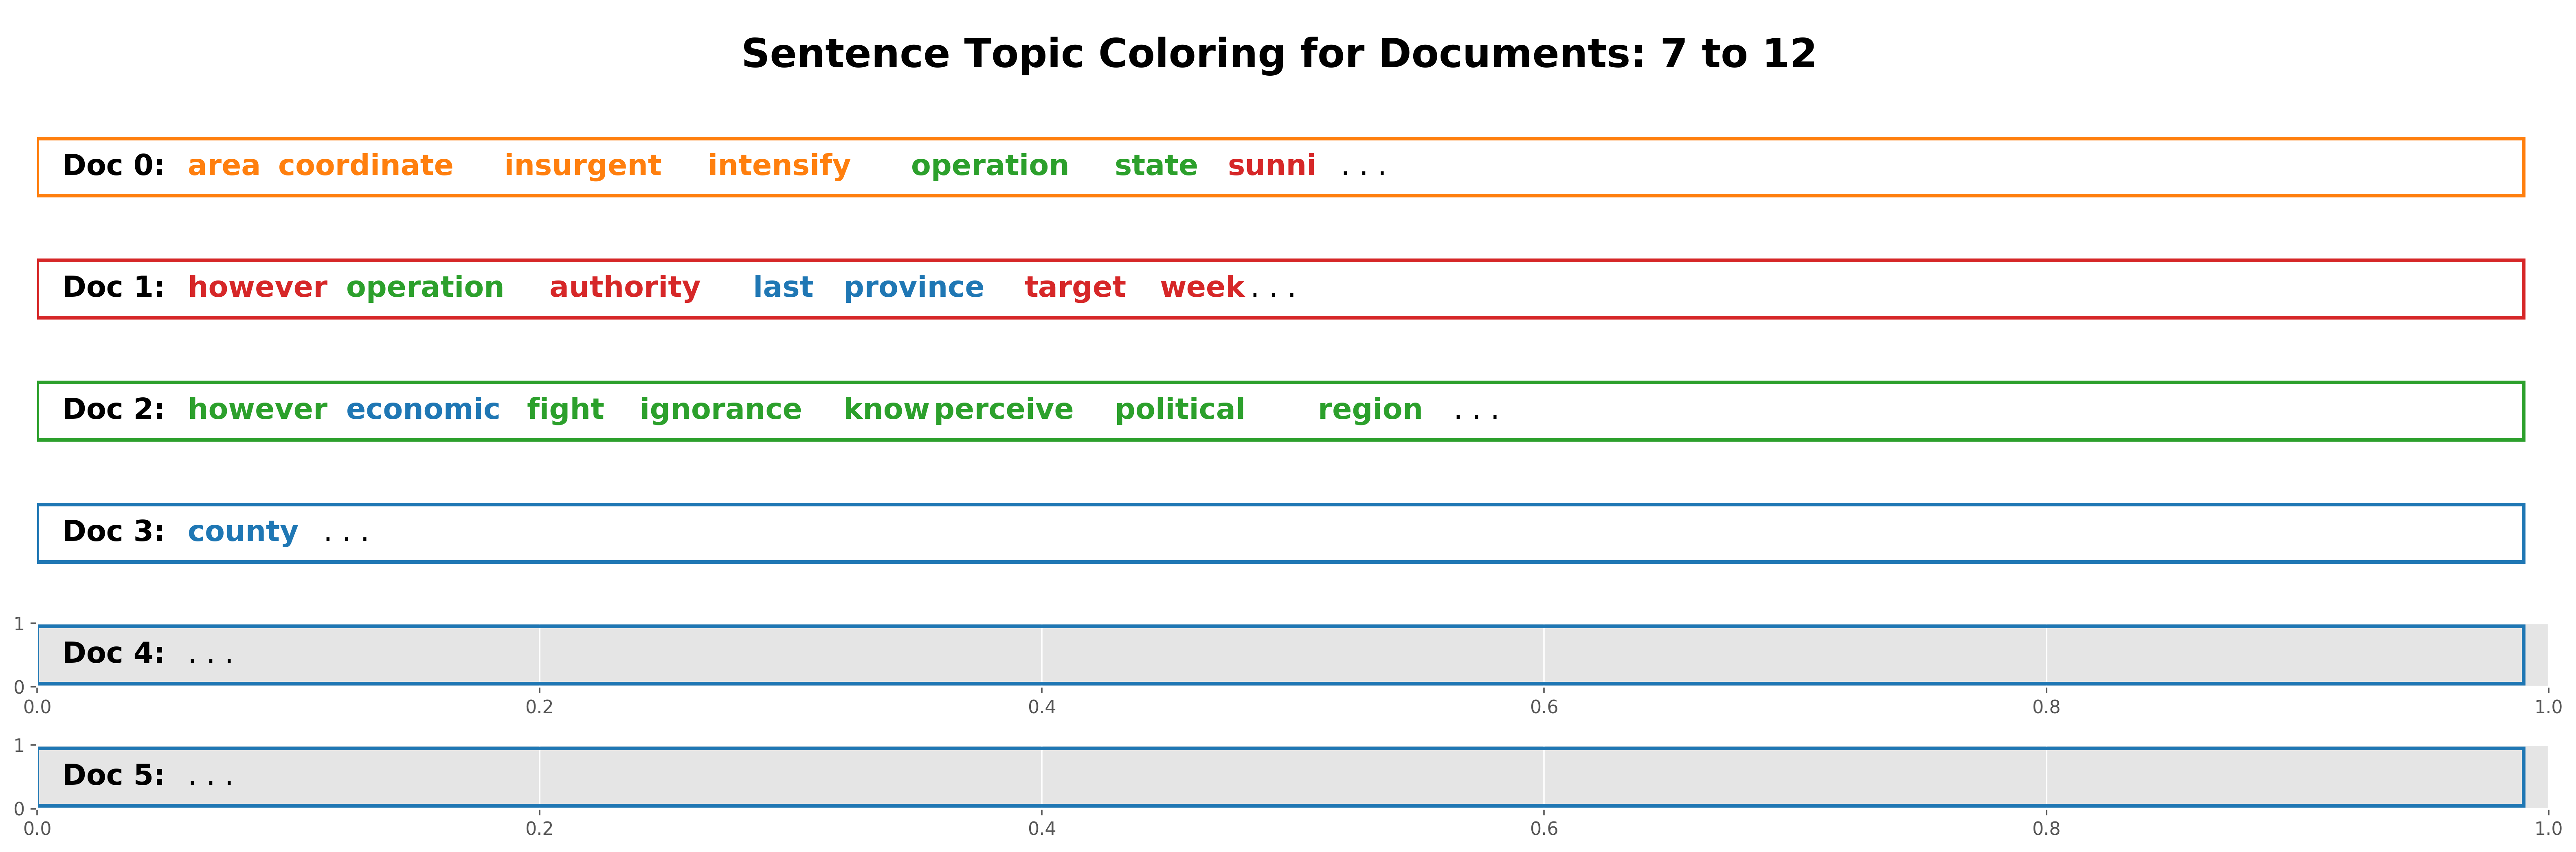

In [24]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle
# Pick documents amongst corpus
def sentences_chart(lda_model=lda_model, corpus=corpus, start = 7, end = 14):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()

We can review the topic percent contribution for each document. Here document 7 is selected as an example.

In [25]:
df_dominant_topic[df_dominant_topic['Document_No']==7]

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
7,7,1.0,0.5309,"however, election, area, attempt, recent, local, schedule, extremist, also, ...","[state, coordinate, intensify, operation, insurgent, sunni, area]"


In [20]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.181791  0.002210       1        1  28.388346
2      0.164227 -0.220917       2        1  28.230551
1      0.018554  0.301764       3        1  23.024395
0     -0.364572 -0.083056       4        1  20.356709, topic_info=        Term         Freq        Total Category  logprob  loglift
4       part  1984.000000  1984.000000  Default  30.0000  30.0000
81    police  1114.000000  1114.000000  Default  29.0000  29.0000
1    however  7073.000000  7073.000000  Default  28.0000  28.0000
2      large  1350.000000  1350.000000  Default  27.0000  27.0000
8        may  1284.000000  1284.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
434   murder    80.161064    80.883537   Topic4  -5.4392   1.5828
529     give    84.888145    85.653854   Topic4  -5.3819   1.5828
129  provide    81.142334    81.874962   Topic4  -5.4270   1.5828
186    place   114.780342   116.777031   Topic4  -5.0802   1.5745
19    target    97.892242   531.822021   Topic4  -5.2394  -0.1007

[171 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
76        2  0.997490     accuse
1494      3  0.990960      ahead
740       4  0.996548  allegedly
382       3  0.996978      allow
58        1  0.564621       also
...     ...       ...        ...
57        1  0.097547     victim
57        2  0.901772     victim
236       2  0.993487     weaken
122       2  0.997530       work
228       3  0.995401      would

[148 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 2, 1])

Interpretation: On the left hand plot, topics are represented by a bubble. Larger bubble size indicates higher prevalence. Good topic model will have fairly big, non-overlapping bubbles scattered throughout the chart. The salient keywords and frequency bars on the right hand chart updates with review of each bubble (cursor over bubble).

### Optimal Topic Size

In [26]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word, random_state=42, update_every=1,\
                                                chunksize=100, passes=10, alpha='symmetric', iterations=100, per_word_topics=True)
        
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [27]:
# Can take a long time to run (10mins approx)
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_ready, start=5, limit=60, step=12)

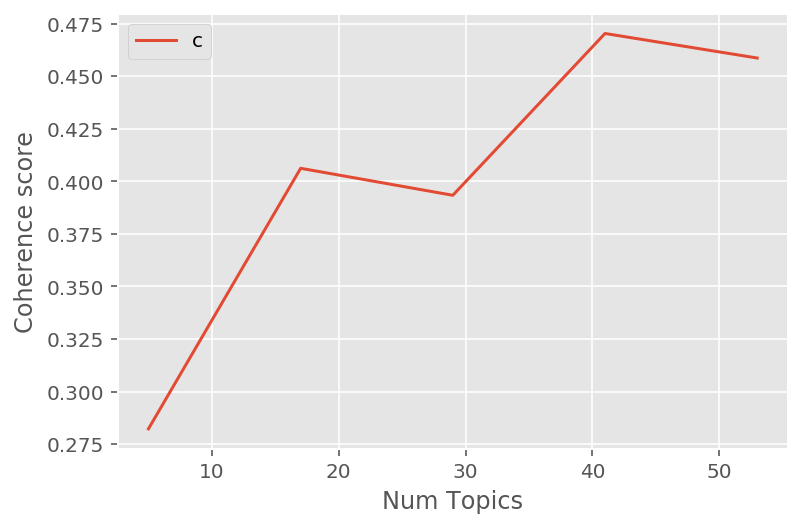

In [28]:
# Show graph
limit=60; start=5; step=12;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [30]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 5  has Coherence Value of 0.2823
Num Topics = 17  has Coherence Value of 0.4062
Num Topics = 29  has Coherence Value of 0.3934
Num Topics = 41  has Coherence Value of 0.4703
Num Topics = 53  has Coherence Value of 0.4587


coherence score saturates at 41 topics. We pick the model with 41 topics.

In [31]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=5))

[(23,
  '0.400*"civilian" + 0.365*"response" + 0.069*"action" + 0.039*"population" + '
  '0.000*"phuket"'),
 (37,
  '0.000*"dictatorship" + 0.000*"phuket" + 0.000*"tradition" + 0.000*"ddd" + '
  '0.000*"grassroot"'),
 (16,
  '0.126*"plan" + 0.120*"country" + 0.117*"include" + 0.095*"office" + '
  '0.093*"education"'),
 (13,
  '0.000*"dictatorship" + 0.000*"phuket" + 0.000*"tradition" + 0.000*"ddd" + '
  '0.000*"grassroot"'),
 (22,
  '0.000*"dictatorship" + 0.000*"phuket" + 0.000*"tradition" + 0.000*"ddd" + '
  '0.000*"grassroot"'),
 (3,
  '0.183*"however" + 0.159*"large" + 0.157*"part" + 0.151*"may" + '
  '0.136*"shiite"'),
 (33,
  '0.387*"prevent" + 0.218*"pilgrim" + 0.021*"travel" + 0.010*"iranian" + '
  '0.000*"phuket"'),
 (14,
  '0.256*"provide" + 0.175*"oil" + 0.077*"colombian" + 0.076*"facility" + '
  '0.000*"ddd"'),
 (30,
  '0.313*"victim" + 0.200*"however" + 0.141*"accuse" + 0.108*"work" + '
  '0.093*"note"'),
 (25,
  '0.533*"however" + 0.420*"election" + 0.000*"recognize" + 0.

The dominant topics in each sentence are identified using the defined function below.

In [32]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,3.0,0.8780,"however, large, part, may, shiite, community, minority, begin, speculate, ph...","[however, speculate, part, large, minority, shiite, community]"
1,1,0.0,0.0244,"student, grassroot, thai, shirt, phuket, dictatorship, ddd, tradition, recog...",[]
2,2,0.0,0.0244,"student, grassroot, thai, shirt, phuket, dictatorship, ddd, tradition, recog...",[]
3,3,3.0,0.8374,"however, large, part, may, shiite, community, minority, begin, speculate, ph...","[however, may, part, large, begin]"
4,4,0.0,0.0244,"student, grassroot, thai, shirt, phuket, dictatorship, ddd, tradition, recog...",[]
5,5,0.0,0.0244,"student, grassroot, thai, shirt, phuket, dictatorship, ddd, tradition, recog...",[]
6,6,0.0,0.0244,"student, grassroot, thai, shirt, phuket, dictatorship, ddd, tradition, recog...",[]
7,7,7.0,0.5030,"sunni, insurgent, intensify, coordinate, ddd, tradition, phuket, decline, th...","[state, coordinate, intensify, operation, insurgent, sunni, area]"
8,8,10.0,0.6042,"authority, however, week, province, last, shirt, ddd, phuket, thai, recognize","[however, authority, operation, target, province, last, week]"
9,9,21.0,0.5749,"political, fight, know, economic, thai, reinvoke, shirt, dictatorship, decli...","[however, know, fight, perceive, political, economic, ignorance, region]"


Find the representative document for each topic and display them.

In [33]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 80

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.6748,"student, grassroot, thai, shirt, phuket, dictatorship, ddd, tradition, recog...","[preventing, student, form, student, wing, college]"
1,2.0,0.8606,"posit, however, victim, informant, release, ransom, kidnap, worker, exchange...","[however, posit, ransom, pay, exchange, release, victim]"
2,3.0,0.8916,"however, large, part, may, shiite, community, minority, begin, speculate, ph...","[however, shiite, may, part, large, shiite, minority, community]"
3,4.0,0.6748,"call, strike, transportation, ddd, tradition, recognize, dictatorship, shirt...","[express, support, strike, call]"
4,6.0,0.7561,"member, however, steal, village, ddd, dictatorship, recognize, phuket, shirt...","[however, official, blame, tribal, member, hand, member, tribe]"
5,7.0,0.5122,"sunni, insurgent, intensify, coordinate, ddd, tradition, phuket, decline, th...","[detention, sunni]"
6,8.0,0.6748,"military, school, however, bus, phuket, ddd, dictatorship, recognize, declin...","[however, device, explode, outside, home, leader, ally, military]"
7,9.0,0.7561,"believe, attempt, however, leave, carry, force, raid, tamil, dictatorship, ddd","[however, believe, attempt, retaliate, measure]"
8,10.0,0.6748,"authority, however, week, province, last, shirt, ddd, phuket, thai, recognize","[however, authority, say, fighter, create, former, leader]"
9,12.0,0.8049,"target, place, celebration, night, ddd, phuket, tradition, thai, dictatorshi...","[target, celebration, mark, change, leadership, place, compound, night]"


In [36]:
# Specify mds as 'tsne', otherwise TypeError: Object of type 'complex' is not JSON serializable
# complex number had come from coordinate calculation and specifying the "mds"
# Ref1: https://stackoverflow.com/questions/46379763/typeerror-object-of-type-complex-is-not-json-serializable-while-using-pyldavi
# Ref2: https://pyldavis.readthedocs.io/en/latest/modules/API.html#pyLDAvis.prepare
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(topic_model=optimal_model, corpus=corpus, dictionary=optimal_model.id2word,mds='tsne')
vis

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
3     -49.935574 -66.702507       1        1  13.427113
30    -96.675003 -34.034245       2        1   6.969122
40    -90.842819   9.449780       3        1   5.779088
2     -97.345917 -14.832421       4        1   5.445899
25    -74.467819 -11.576441       5        1   5.421485
9     -76.932564 -52.698208       6        1   4.322674
29    -72.373123  27.664944       7        1   4.151739
32    -69.033562 -30.171061       8        1   3.674342
38     87.887772   3.473363       9        1   3.302971
6     -46.730114 -39.906811      10        1   3.060985
39    -20.435946 -72.516670      11        1   2.918294
23     66.762886 -21.325079      12        1   2.561099
8     -44.003128  28.908051      13        1   2.534384
17    -62.789299   4.183098      14        1   2.482942
35    -32.503456 -21.501902      15        1   2.456744
24    -53.233795 -14.308000      16        1   2.254669
15     69.735687  39.867153      17        1   2.168946
16     -2.715930 -49.286213      18        1   2.057855
34     57.713737 -53.868393      19        1   1.984665
12    -30.597052  62.687122      20        1   1.943124
10    -37.065296   3.944219      21        1   1.942746
27     31.262344  63.857933      22        1   1.931905
7       1.582384  65.657547      23        1   1.672776
21     24.489946 -58.959492      24        1   1.661208
4      42.898003  38.224339      25        1   1.559425
28     60.252510  10.420552      26        1   1.257679
14    -14.149649  40.510651      27        1   1.119331
33     40.311119 -33.464424      28        1   1.026356
0      16.560863  41.609417      29        1   0.793227
11     37.929207  14.580170      30        1   0.676434
13     20.396595  21.167330      31        1   0.676434
18    -11.488786  -4.159511      32        1   0.676434
19      7.769625 -10.708549      33        1   0.676434
22     22.571497   2.084885      34        1   0.676434
26     26.253345 -16.430779      35        1   0.676434
5       4.548679   7.536098      36        1   0.676434
31     -6.576188 -24.028250      37        1   0.676434
36    -14.964123  15.578209      38        1   0.676434
37     13.871904 -31.089712      39        1   0.676434
1       1.868730  26.176788      40        1   0.676434
20     42.455063  -6.255538      41        1   0.676434, topic_info=                Term         Freq         Total Category  logprob  loglift
1            however  12568.00000  12568.000000  Default  30.0000  30.0000
4               part   2978.00000   2978.000000  Default  29.0000  29.0000
81            police   2140.00000   2140.000000  Default  28.0000  28.0000
50            member   1905.00000   1905.000000  Default  27.0000  27.0000
14             state   2306.00000   2306.000000  Default  26.0000  26.0000
...              ...          ...           ...      ...      ...      ...
1786        symbolic      0.11283      2.891442  Topic41  -8.6008   1.7525
1787    steal_weapon      0.11283      2.891442  Topic41  -8.6008   1.7525
1788          larger      0.11283      2.891442  Topic41  -8.6008   1.7525
1789          biased      0.11283      2.891442  Topic41  -8.6008   1.7525
1790  media_coverage      0.11283      2.891442  Topic41  -8.6008   1.7525

[2314 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
141      18  0.982823   accord
76        2  0.996623   accuse
195      12  0.983621   action
105       3  0.987152   allege
58        9  0.997320     also
...     ...       ...      ...
52       10  0.977499  village
138       2  0.974178     wave
20       21  0.988772     week
122       2  0.995440     work
104       4  0.987001   worker

[147 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 31, 41, 3, 26, 10, 30, 33, 39, 7, 40, 24, 9, 18, 36, 25, 16, 17, 35, 13, 11, 28, 8, 22, 5, 29, 15, 34

### Binary Classification (LDA topic features)

In [34]:
# Set the dictionary and corpus based on trainsub data
trainid2word = id2word
traincorpus = corpus

In [35]:
# Train model 
# Build LDA model on trainsub data, using optimum topics
lda_train = gensim.models.ldamodel.LdaModel(corpus=traincorpus,
                                           id2word=trainid2word,
                                           num_topics=41, 
                                           random_state=42,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

With the LDA model trained on train data, run the motive text through it using 'get document topics'. A list comprehension on that output (2nd line in loop) will give the probability distribution of the topics for a specific review (feature vector). 

In [37]:
# Make train Vectors
train_vecs = []
for i in range(len(X_train)):
    top_topics = lda_train.get_document_topics(traincorpus[i], minimum_probability=0.0)
    topic_vec = [top_topics[i][1] for i in range(41)]
    train_vecs.append(topic_vec)

In [38]:
# Sanity check; should correspond with the number of optimal topics
print(f"Number of vectors per train text: {len(train_vecs[2])}")

print(f"Length of train vectors: {len(train_vecs)}")
print(f"Length of X_train: {len(X_train)}")

Number of vectors per train text: 41
Length of train vectors: 26016
Length of X_train: 26016


In [39]:
# Pass the vectors into numpy array form
X_tr_vec = np.array(train_vecs)
y_tr = np.array(y_train)

In [40]:
# Split the train_vecs for training
X_trainsub,X_validate,y_trainsub,y_validate = train_test_split(X_tr_vec,y_tr,test_size=0.20,stratify=y_tr,random_state=42)

In [41]:
# Instantiate model
lr = LogisticRegression(random_state=42,solver='lbfgs',max_iter=500)

# Fit model 
model_lr = lr.fit(X_trainsub,y_trainsub)

In [42]:
# Generate predictions from validate set
# Cross-validate 10 folds
predictions = cross_val_predict(model_lr, X_validate, y_validate, cv = 10)
print(f"Accuracy on validate set: {round(cross_val_score(model_lr, X_validate, y_validate, cv = 10).mean(),4)}")

Accuracy on validate set: 0.582


In [43]:
# Confusion matrix for test set using NB model
# Pass in true values, predicted values to confusion matrix
# Convert Confusion matrix into dataframe
# Positive class (class 1) is bomb
cm = confusion_matrix(y_validate, predictions)
cm_df = pd.DataFrame(cm,columns=['pred non-bomb','pred bomb'], index=['Actual non-bomb','Actual bomb'])
cm_df

,pred non-bomb,pred bomb
Actual non-bomb,1039,1685
Actual bomb,490,1990


In [44]:
# return nparray as a 1-D array.
confusion_matrix(y_validate, predictions).ravel()

# Save TN/FP/FN/TP values.
tn, fp, fn, tp = confusion_matrix(y_validate, predictions).ravel()

# Summary of metrics for LR model
spec = tn/(tn+fp)
sens = tp/(tp+fn)
print(f"Specificity: {round(spec,4)}")
print(f"Sensitivity: {round(sens,4)}")

# To compute the ROC AUC curve, first
# Create a dataframe called pred_df that contains:
# 1. The list of true values of our test set.
# 2. The list of predicted probabilities based on our model.

pred_proba = [i[1] for i in lr.predict_proba(X_validate)]

pred_df = pd.DataFrame({'test_values': y_validate,
                        'pred_probs':pred_proba})

# Calculate ROC AUC.
print(f"roc_auc: {round(roc_auc_score(pred_df['test_values'],pred_df['pred_probs']),4)}")

Specificity: 0.3814
Sensitivity: 0.8024
roc_auc: 0.6121


In [45]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
data = X_test.motive.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])

<>:3: DeprecationWarning: invalid escape sequence \s
<>:3: DeprecationWarning: invalid escape sequence \s
<>:3: DeprecationWarning: invalid escape sequence \s
<ipython-input-45-f82c2e9a857b>:3: DeprecationWarning: invalid escape sequence \s
  sent = re.sub('\s+', ' ', sent)  # remove newline chars


[['the', 'specific', 'motive', 'for', 'the', 'attack', 'is', 'unknown']]


In [46]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    # use 'en_core_web_sm' in place of 'en' 
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data

In [47]:
# Using train dict on new unseen test words
testcorpus = [trainid2word.doc2bow(text) for text in data_ready]

In [48]:
# Use the LDA model from trained data on the unseen test corpus
# Code block similar to that for training code, except 
# use the LDA model from the training data, and run them through the unseen test reviews
test_vecs = []
for i in range(len(X_test)):
    top_topics = lda_train.get_document_topics(testcorpus[i], minimum_probability=0.0)
    topic_vec = [top_topics[i][1] for i in range(41)]
    test_vecs.append(topic_vec)

In [49]:
print(f"Length of test vectors: {len(test_vecs)}")
print(f"Length of X_test: {len(X_test)}")

Length of test vectors: 6505
Length of X_test: 6505


In [50]:
# Pass the vectors into numpy array form
X_ts_vec = np.array(test_vecs)
y_ts = np.array(y_test)

In [51]:
# Instantiate model
lr = LogisticRegression(random_state=42,solver='lbfgs',max_iter=500)

# Fit model 
model_lr = lr.fit(X_ts_vec,y_ts)

# Generate predictions from test set
predictions = lr.predict(X_ts_vec)
print(f"Accuracy on test set: {round(model_lr.score(X_ts_vec, y_ts),4)}")

Accuracy on test set: 0.6034


In [52]:
# Confusion matrix for test set using NB model
# Pass in true values, predicted values to confusion matrix
# Convert Confusion matrix into dataframe
# Positive class (class 1) is bomb
cm = confusion_matrix(y_ts, predictions)
cm_df = pd.DataFrame(cm,columns=['pred non-bomb','pred bomb'], index=['Actual non-bomb','Actual bomb'])
cm_df

,pred non-bomb,pred bomb
Actual non-bomb,1412,1993
Actual bomb,587,2513


In [53]:
# return nparray as a 1-D array.
confusion_matrix(y_ts, predictions).ravel()

# Save TN/FP/FN/TP values.
tn, fp, fn, tp = confusion_matrix(y_ts, predictions).ravel()

# Summary of metrics for LR model
spec = tn/(tn+fp)
sens = tp/(tp+fn)
print(f"Specificity: {round(spec,4)}")
print(f"Sensitivity: {round(sens,4)}")

# To compute the ROC AUC curve, first
# Create a dataframe called pred_df that contains:
# 1. The list of true values of our test set.
# 2. The list of predicted probabilities based on our model.

pred_proba = [i[1] for i in lr.predict_proba(X_ts_vec)]

pred_df = pd.DataFrame({'test_values': y_ts,
                        'pred_probs':pred_proba})

# Calculate ROC AUC.
print(f"roc_auc: {round(roc_auc_score(pred_df['test_values'],pred_df['pred_probs']),4)}")

Specificity: 0.4147
Sensitivity: 0.8106
roc_auc: 0.6374


In [55]:
# Summary of the topic modeling + LR model scores in Dataframe
summary_df = pd.DataFrame({'accuracy' : [0.5820, 0.6034],
                          'specificity' : [0.3814, 0.4147],
                          'sensitivity' : [0.8024, 0.8106],
                          'roc_auc' : [0.6121, 0.6374]})
# Transpose dataframe
summary_dft = summary_df.T
# Rename columns
summary_dft.columns = ['Validate set','Test set']
print("Topic modeling + LR classifier scores: ")
display(summary_dft)

Topic modeling + LR classifier scores: 


,Validate set,Test set
accuracy,0.5820,0.6034
specificity,0.3814,0.4147
sensitivity,0.8024,0.8106
roc_auc,0.6121,0.6374


From the sensitivity and roc_auc score, the model is not overfitted as test sensitivity and roc_auc is higher than on validate set. Before proceeding, a recap on the steps done to consolidate understanding.

- Topic modeling using the train dataset,
- Find optimum topics based on coherence score
- Train LDA model on train data. The probability distributions of the topics are then used as feature vectors in the Logistic Regression model for binary classification (bomb vs. non-bomb) on the validate data set. 
- Thereafter, the trained LDA model is used to derive probability distributions of the topics from the test data. 
- Run Logistic Regression model on these topic probability distributions, to see if model generalizes

In the next section, the  topic probability distributions are added to the count vectorized word features for both train and test dataset. The dataset is then run through the Logistic Regression model to determine overall model generalizability

### Binary Classification (LDA topic and Countvectorizer features)

In [56]:
# Instantiate porterstemmer
p_stemmer = PorterStemmer()

In [57]:
# Define function to convert a raw selftext to a string of words

def selftext_to_words(motive_text):
    
    # 1. Remove non-letters.
    letters_only = re.sub("[^a-zA-Z]", " ", motive_text)
    
    # 2. Split into individual words
    words = letters_only.split()
    
    # 3. In Python, searching a set is much faster than searching
    # a list, so convert the stopwords to a set.
    stops = set(stop_words)

    # 5. Remove stopwords.
    meaningful_words = [w for w in words if w not in stops]
    
    # 5.5 Stemming of words
    meaningful_words = [p_stemmer.stem(w) for w in words]
    
    # 6. Join the words back into one string separated by space, 
    # and return the result
    return(" ".join(meaningful_words))

In [58]:
#Initialize an empty list to hold the clean test text.
X_train_clean = []
X_test_clean = []

for text in X_train['motive']:
    """Convert text to words, then append to X_train_clean."""
    X_train_clean.append(selftext_to_words(text))
for text in X_test['motive']:
    """Convert text to words, then append to X_train_clean."""
    X_test_clean.append(selftext_to_words(text))

In [59]:
# Instantiate our CountVectorizer
cv = CountVectorizer(ngram_range=(1,2),max_df=0.9,min_df=3,max_features=10000)

# Fit and transform on whole training data
X_train_cleancv = cv.fit_transform(X_train_clean)

# Transform test data
X_test_cleancv = cv.transform(X_test_clean)

In [60]:
# Add word vectors (topic modeling) to the sparse matrices
# Ref: https://stackoverflow.com/questions/55637498/numpy-ndarray-sparse-matrix-to-dense
# Ref: https://kite.com/python/docs/scipy.sparse

# Convert sparse matrix to dense
X_tr_dense = X_train_cleancv.toarray()
X_ts_dense = X_test_cleancv.toarray()

# add numpy array (train and test topic model vectors to dense matrix)
X_tr_dense_tm = np.concatenate((X_tr_dense,X_tr_vec),axis=1)
X_ts_dense_tm = np.concatenate((X_ts_dense,X_ts_vec),axis=1)

In [61]:
from scipy.sparse import csr_matrix
# Convert back to sparse matrix for modeling
X_tr_sparse = csr_matrix(X_tr_dense_tm)
X_ts_sparse = csr_matrix(X_ts_dense_tm)

In [62]:
# Sanity Check
display(X_tr_sparse)
display(X_train_cleancv)

<26016x10041 sparse matrix of type '<class 'numpy.float64'>'
	with 1793005 stored elements in Compressed Sparse Row format>

<26016x10000 sparse matrix of type '<class 'numpy.int64'>'
	with 726349 stored elements in Compressed Sparse Row format>

---

In [63]:
# Instantiate model
lr_comb = LogisticRegression(random_state=42,solver='lbfgs',max_iter=500)

# Fit model on whole training data (without addn set of stopwords removed in NB model)
model_lr = lr_comb.fit(X_tr_sparse,y_train)

# Generate predictions from test set
predictions = lr_comb.predict(X_ts_sparse)
print(f"Accuracy on whole test set: {round(model_lr.score(X_ts_sparse, y_test),4)}")

Accuracy on whole test set: 0.6893


In [64]:
# Confusion matrix for test set using NB model
# Pass in true values, predicted values to confusion matrix
# Convert Confusion matrix into dataframe
# Positive class (class 1) is bomb
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(cm,columns=['pred non-bomb','pred bomb'], index=['Actual non-bomb','Actual bomb'])
cm_df

,pred non-bomb,pred bomb
Actual non-bomb,1822,1583
Actual bomb,438,2662


In [65]:
# return nparray as a 1-D array.
confusion_matrix(y_test, predictions).ravel()

# Save TN/FP/FN/TP values.
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()

# Summary of metrics for LR model
spec = tn/(tn+fp)
sens = tp/(tp+fn)
print(f"Specificity: {round(spec,4)}")
print(f"Sensitivity: {round(sens,4)}")

# To compute the ROC AUC curve, first
# Create a dataframe called pred_df that contains:
# 1. The list of true values of our test set.
# 2. The list of predicted probabilities based on our model.

pred_proba = [i[1] for i in lr_comb.predict_proba(X_ts_sparse)]

pred_df = pd.DataFrame({'test_values': y_test,
                        'pred_probs':pred_proba})

# Calculate ROC AUC.
print(f"roc_auc: {round(roc_auc_score(pred_df['test_values'],pred_df['pred_probs']),4)}")

Specificity: 0.5351
Sensitivity: 0.8587
roc_auc: 0.7621


In [67]:
# Summary of the topic modeling + LR model scores in Dataframe
summary_df = pd.DataFrame({'accuracy' : [0.6859, 0.6034, 0.6893],
                          'specificity' : [0.5257, 0.4147, 0.5351],
                          'sensitivity' : [0.8619, 0.8106, 0.8587],
                          'roc_auc' : [0.7568, 0.6374, 0.7621]})
# Transpose dataframe
summary_dft = summary_df.T
# Rename columns
summary_dft.columns = ['LR model (50 false neg wrd rmvd)','LR model (tm)', 'LR model (tm + wrd vec)']
display(summary_dft)

,LR model (50 false neg wrd rmvd),LR model (tm),LR model (tm + wrd vec)
accuracy,0.6859,0.6034,0.6893
specificity,0.5257,0.4147,0.5351
sensitivity,0.8619,0.8106,0.8587
roc_auc,0.7568,0.6374,0.7621


### Recommendations (Part2)

From the model metric summaries, the model using topic distributions alone as feature vectors has the lowest performance scores (sensitivity and roc_auc). The addition of feature vectors from count vectorizer improved model sensitivity and roc_auc. Model generalizability using LDA topic distributions has been demonstrated, though the best performing model remains the production Logistic Regression model using count vectorized word features. Nevertheless, the results are encouraging, and could be further experimented upon (some prelim thoughts are listed under future work).

The approach applied in this project could work in general, for similar NLP-based classifiers.

### Future Work

Terrorism is a complex topic as it covers politics, psychology, philosophy, military strategy, etc. The current model is a very simplistic model in that it classifies a terrorist attack mode as 'bomb' or 'non-bomb' based solely on one form of intel (motive text). Additional sources or forms of intel are not included, nor political and social factors trends that could serve as supporting sources of intelligence.

Here are a few areas that I would like to revisit for future project extensions:
- source for additional data to widen perspective
- feature engineer spatial and temporal aspects (e.g. attacks by region, attacks by decades)
- explore model performance using Tfidf vectorizer and spaCy
- explore other classification models (currently only 2 models explored; time allocated between studying the dataset variables, motive texts, longer than usual modeling times with the inherent size of the dataset, and research on topic modeling (LDA) and spaCy)

---